<a href="https://colab.research.google.com/github/prasadanvekar/elvtrdocs/blob/main/SampleStocktesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Actual_Close,Target,Close,Volume,Open,High,Low
1996-01-01 18:30:00,10.359912,0.0,10.441107,48051995.0,10.403047,10.458868,10.334539
1996-01-02 18:30:00,10.438572,1.0,10.359912,77875009.0,10.415733,10.466480,10.283792
1996-01-03 18:30:00,10.342154,0.0,10.438572,96602936.0,10.529916,11.009471,10.415736
1996-01-04 18:30:00,10.271108,0.0,10.342154,100099436.0,10.339616,10.372602,10.202600
1996-01-07 18:30:00,9.860059,0.0,10.271108,76935930.0,10.301556,10.301556,10.182301


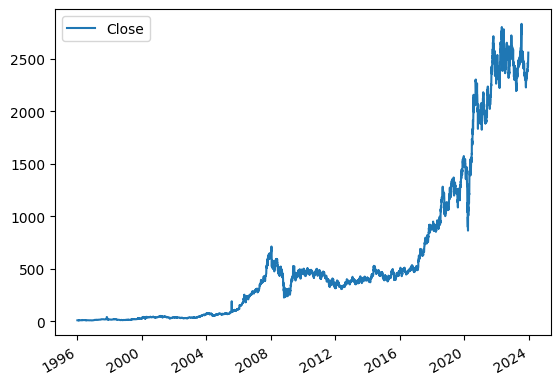

In [5]:
# Import finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np


DATA_PATH = "reliance_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("RELIANCE.NS")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

data.head(5)

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

